Camryn Mullin 260926298 Assignment 6 PHYS 512

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import glob
import os
from scipy.interpolate import interp1d
import scipy.signal as sig


Bad key "text.kerning_factor" on line 4 in
//anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
directory = 'problem_sets/ps6/LOSC_Event_tutorial'

def read_template(fname):
    dataFile = h5py.File(fname,'r')
    template = dataFile['template']
    th = template[0] #Hanford
    tl = template[1] #Livingston
    return th,tl

def read_file(fname):
    dataFile = h5py.File(fname,'r')
    dqInfo = dataFile['quality']['simple']
    qmask = dqInfo['DQmask'][...]
    meta = dataFile['meta']
    
    gpsStart = meta['GPSstart'][()]
    utc = meta['UTCstart'][()]
    duration = meta['Duration'][()]
    strain = dataFile['strain']['Strain'][()]
    
    dt = (float(duration))/len(strain)
    dataFile.close()
    return strain, dt, utc

In [3]:
files = os.listdir('LOSC_Event_tutorial')
templates = [file for file in files if file[-13:] == "template.hdf5"]
H_files = [file for file in files if file[:3] == "H-H"]
L_files = [file for file in files if file[:3] == "L-L"]

In [4]:
#need to update file names with missing LOSC_Event_tutorial part
def add_path(files):
    for i in range(len(files)):
        files[i] = 'LOSC_Event_tutorial/' + files[i]
    return files

#update the file paths
templates = add_path(templates); H_files = add_path(H_files); L_files = add_path(L_files)

In [5]:
def get_strain(files):
    strain_arr = []
    dt_arr = []
    utc_arr = []
    for file in files:
        print('reading file ',file)
        strain, dt, utc = read_file(file)
        strain_arr.append(strain); dt_arr.append(dt); utc_arr.append(utc)
    return np.array(strain_arr), np.array(dt_arr), np.array(utc_arr)  

strain_H1, dt_H1, utc_H1 = get_strain(H_files)
strain_L1, dt_L1, utc_L1 = get_strain(L_files)

reading file  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5
reading file  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1128678884-32.hdf5
reading file  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5
reading file  LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5
reading file  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5
reading file  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5
reading file  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5
reading file  LOSC_Event_tutorial/L-L1_LOSC_4_V1-1167559920-32.hdf5


In [6]:
#template_name = 'LOSC_Event_tutorial/GW_events/GW150914_4_template.hdf5'
th = []
tl = []
for template in templates:
    print('reading template ',template)
    th_i, tl_i = read_template(template)
    th.append(th_i); tl.append(tl_i)
th = np.array(th); tl = np.array(tl)

reading template  LOSC_Event_tutorial/GW150914_4_template.hdf5
reading template  LOSC_Event_tutorial/GW151226_4_template.hdf5
reading template  LOSC_Event_tutorial/LVT151012_4_template.hdf5
reading template  LOSC_Event_tutorial/GW170104_4_template.hdf5


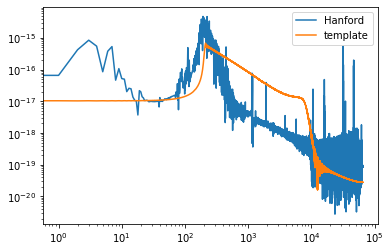

In [7]:
plt.loglog(np.abs(np.fft.rfft(strain_H1[2])), label='Hanford')
plt.loglog(np.abs(np.fft.rfft(th[0])), label='template')
plt.legend()

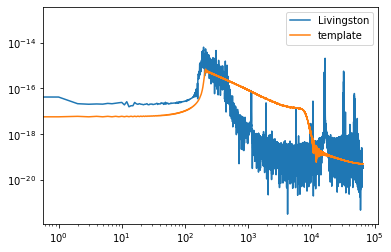

In [8]:
plt.loglog(np.abs(np.fft.rfft(strain_L1[2])), label='Livingston')
plt.loglog(np.abs(np.fft.rfft(tl[0])), label='template')
plt.legend()

Question a)

Window function used is Tukey window with function described in window funcition wikipedia. This window is good because it is smooth at the edges and flat in the middle, which is desirable in this case.

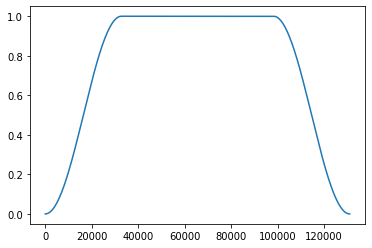

In [9]:
def tukey_window(N,alpha=0.5):
    '''A window function that is smooth at the edges
    and flat in the middle
    '''
    window = np.ones(N)
    n = np.arange(alpha*N/2)
    edge = 0.5*(1 - np.cos(2*np.pi*n/(alpha*N)))
    window[:int(alpha*N/2)] = edge
    #window is symetric
    window[-int(alpha*N/2):] = edge[::-1]
    return window

n = len(strain_H1[0])                                                                    
window = tukey_window(n)
plt.plot(window)

To get the noise models, start by calculating the fft of the strain for each detector. The strains in this fft are windowed. See "sft" below. 

Next, a simpel noise model is calculated for each seen in "get_nft" below. The strain fourier transofrms are averaged across the 4 events in an attempt to extract the noise from the signal, since the noise will be roughly the same for each event, but the signal will differ. The averaged values of the strain fft is then squared and absolute valued to return the noise. 

To smooth the noise, the result of "get_Nft" is convolved with a normalized gaussin function centered at 0. See "conv". Lastly, any remaining spikes are somewhat flattened out by convoling agian with an array of ones; "remove_peaks".

In [14]:
#to get the strain fourier transform
def sft(window,strain):
    first = np.fft.rfft(window*strain[0])
    strain_ft = np.empty([4,len(first)], dtype = 'complex')
    strain_ft[0] = first
    for i in range(1,4):
        strain_ft[i] = np.fft.rfft(window*strain[i])
    return strain_ft

def get_Nft(strain_ft):
    strain_ft = np.mean(strain_ft,axis=0) 
    return np.abs(strain_ft)**2
    
#smoothing
def gauss(x,b,sig=False):
    if sig:
        return np.exp(-0.5*(x-b)**2/sig**2)
    return np.exp(-0.5*(x-b)**2)
def conv(f,g):
    return np.fft.irfft(np.fft.rfft(f)*np.fft.rfft(g),len(f))

def remove_peaks(Nft,n):
    return np.convolve(Nft,np.ones(n)/n,mode='same')


Hanford detector

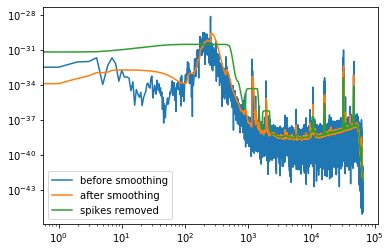

In [15]:
#strain ft for Hanford detection
strain_ft_H1 = sft(window,strain_H1)

Nft_H1 = get_Nft(strain_ft_H1)#noise
plt.loglog(Nft_H1, label='before smoothing')

freq = np.linspace(0,2048,len(Nft_H1))
g = gauss(freq,0,sig=0)
g/=sum(g)

Nft_H1 = conv(Nft_H1,g)
plt.loglog(Nft_H1, label='after smoothing')

Nft_H1 = remove_peaks(Nft_H1,500)
plt.loglog(Nft_H1, label = 'spikes removed')

plt.legend()
plt.savefig('Power spectrum H1.png')

Livingston detector

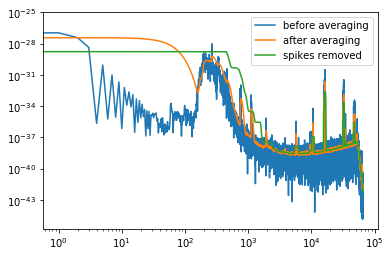

In [16]:
#strain ft for Livingston detector
strain_ft_L1 = sft(window,strain_L1)
    
Nft_L1 = get_Nft(strain_ft_L1)
plt.loglog(Nft_L1, label='before averaging')

Nft_L1 = conv(Nft_L1,g)
plt.loglog(Nft_L1, label='after averaging')

Nft_L1 = remove_peaks(Nft_L1,900)
plt.loglog(Nft_L1, label = 'spikes removed')

plt.legend()
plt.savefig('Power spectrum L1.png')

Question b)

In [17]:
#re-order templates to match detector orders
idx = [2,1,0,3]
th = th[idx]; tl = tl[idx]

The strain fourier transforms for each detector are pre-whitened as seen below by dividing the strain fft by the sqrt of the noise and again by the frequency 4096 found in the JSON file. The templates are whitened in the same manner

In [18]:
#pre-whitening
def whiten(strain_ft,Nft):
    sft_white = np.empty([4,len(strain_ft[0])], dtype = 'complex')
    for i in range(4):  
        sft_white[i] = strain_ft[i]/np.sqrt(Nft)/4096
    return sft_white

strain_ft_white_H1 = whiten(strain_ft_H1,Nft_H1)
strain_ft_white_L1 = whiten(strain_ft_L1,Nft_L1)
    
tft_white_H1 = whiten(sft(window,th),Nft_H1)
tft_white_L1 = whiten(sft(window,th),Nft_L1)


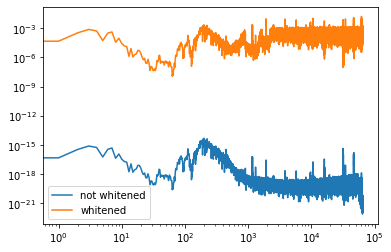

In [19]:
plt.loglog(np.abs(strain_ft_H1[2]), label = 'not whitened')
plt.loglog(np.abs(strain_ft_white_H1[2]), label = 'whitened')
plt.legend()
plt.savefig('strain_whitening_H1.png')

To match filter, the cross correlation of the whitened strain fft with the respective whitened template is taken. 

In [20]:
#matched filters
def xcorr(sft_white,tft_white):
    cross_corr = np.empty([4,131072], dtype = 'complex')
    for i in range(4):
        cross_corr[i] = (np.fft.irfft(sft_white[i]*np.conj(tft_white[i])))
    return cross_corr
  
cross_corr_H1 = xcorr(strain_ft_white_H1,tft_white_H1)
cross_corr_L1 = xcorr(strain_ft_white_L1,tft_white_L1)


//anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


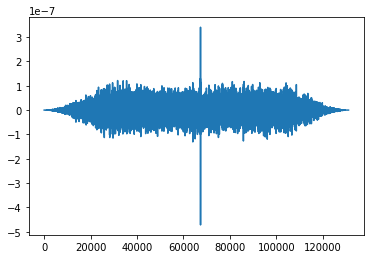

In [21]:
cross_corr_rolled_H1 = np.roll(cross_corr_H1,len(cross_corr_H1[2])//2,axis=1)

cross_corr_rolled_L1 = np.roll(cross_corr_L1,len(cross_corr_L1[2])//2,axis=1)

plt.plot(cross_corr_rolled_H1[2])
#plt.plot(cross_corr_H1[2])

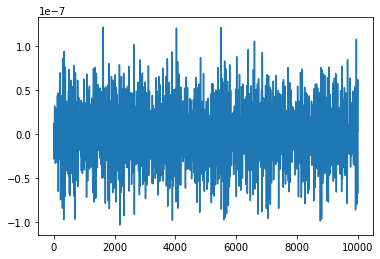

In [22]:
trimmed_H1 = cross_corr_rolled_H1[2][30000:40000]
plt.plot(trimmed_H1)

Question c)

The noise estimate is done by taking the standard deviation of the absolute value of the cross correlation in a region that apperas to be all noise. This gives an estimate of noise in the signal. See "get_noise" below. 

In [23]:
#noise for each detection
def get_noise(xcorr, n,m):
    return np.std(np.abs(xcorr[:,n:m]))
n = 30000
m = 40000
my_noise_H1 = get_noise(cross_corr_rolled_H1,n,m)
my_noise_L1 = get_noise(cross_corr_rolled_L1,n,m)
#combined
my_noise_comb = get_noise(cross_corr_rolled_H1+cross_corr_rolled_L1,n,m)
print(my_noise_H1), print(my_noise_L1);print(my_noise_comb)

1.583277365110851e-08
1.5018595245949973e-08
2.1161792310684043e-08


The value of SNR is then simply the maximum value in the cross correlation along each axis, which is divided by the noise found above. The get the combined SNR, add the cross correlations in the funciton for obtaining noise and SNR.

In [24]:
#snr for each detetion
def snr(cross_corr,noise):
    snr = np.abs(cross_corr)/noise
    snr_max = np.argmax(snr,axis=1)
    return snr,snr_max

snr_H1,snr_max_H1 = snr(cross_corr_rolled_H1,my_noise_H1) #Hangford
snr_L1,snr_max_L1 = snr(cross_corr_rolled_L1,my_noise_L1) #Livingston
snr_comb,snr_max_comb = snr(cross_corr_rolled_H1+cross_corr_rolled_L1, my_noise_comb)

for i in range(4):
    print('Hanford',snr_H1[i][snr_max_H1[i]])
for i in range(4):
    print('Livinston',snr_L1[i][snr_max_L1[i]])
for i in range(4):
    print('comb',snr_comb[i][snr_max_comb[i]])

Hanford 4.95786640144639
Hanford 3.443934793428231
Hanford 29.81811525143267
Hanford 11.45796348119638
Livinston 6.106828590277178
Livinston 3.561574699139141
Livinston 23.126743023028748
Livinston 11.471161334287443
comb 6.074652785824665
comb 3.4274489116161093
comb 23.053425402450802
comb 14.03558683521797


Text(0.5, 1.0, 'Combined')

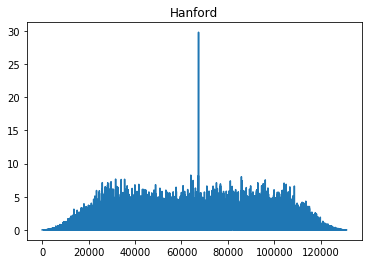

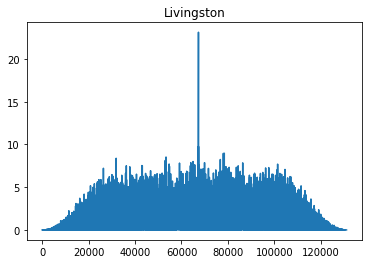

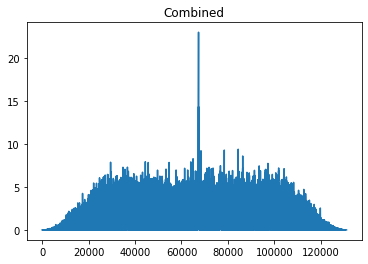

In [25]:
plt.figure()
plt.plot(snr_H1[2])
plt.title('Hanford')
plt.figure()
plt.plot(snr_L1[2])
plt.title('Livingston')
plt.figure()
plt.plot(snr_comb[2])
plt.title('Combined')

Question d)

The signal to noise reference can be obtained by taking the cross correlation of the whitened templates with themselves. This is tehn summed and square rooted. This will give an estimate for noise. The SNR is simply "snr" of the cross correlations with this noise.

In [26]:
#get noise
corr_H1 = xcorr(tft_white_H1,tft_white_H1)
corr_L1 = xcorr(tft_white_L1,tft_white_L1)

noise_reff_H1 = np.sqrt(np.abs(np.sum(corr_H1)))
noise_reff_L1 = np.sqrt(np.abs(np.sum(corr_L1)))
noise_reff_comb = np.sqrt(np.abs(np.sum(corr_H1+corr_L1)))
print(noise_reff_H1);print(noise_reff_L1);print(noise_reff_comb)

5.628786148960468e-08
3.417934816308133e-09
5.6391418469074676e-08


In [27]:
#get snr
snr_reff_H1,snr_reff_H1_max = snr(cross_corr_rolled_H1,noise_reff_H1)
snr_reff_L1,snr_reff_L1_max = snr(cross_corr_rolled_L1,noise_reff_L1)
snr_reff_comb,snr_reff_comb_max = snr(cross_corr_rolled_H1+cross_corr_rolled_L1,noise_reff_comb)
for i in range(4):
    print('Hanford',snr_reff_H1[i][snr_reff_H1_max[i]])
for i in range(4):
    print('Livinston',snr_reff_L1[i][snr_reff_L1_max[i]])
for i in range(4):
    print('comb',snr_reff_comb[i][snr_reff_comb_max[i]])

Hanford 1.3945595808615585
Hanford 0.9687175637965293
Hanford 8.387305130890232
Hanford 3.222921203605379
Livinston 26.833743696971617
Livinston 15.649756861765912
Livinston 101.62019215894072
Livinston 50.40491944394153
comb 2.2796117583677655
comb 1.286205667319337
comb 8.651170934528839
comb 5.267081084834566


The SNR obtained here is within the order of magnitude for what was obtined by the matched filter for Hanford and combined. Livinston however was 1 order of maginitude off.

Question e)

To find the indexes where half the power is above and half is below, check for the frequency at which the sum of the power up to that point is greater than or equal to half of the total power

In [28]:
power_H1 = np.abs(tft_white_H1)
power_L1 = np.abs(tft_white_L1)

def find_half(power):
    found_freq = []
    for i in range(4):
        total = np.sum(power[i])
        freqs = np.fft.rfftfreq(len(th[0]),1/4096)
        sum_power = 0
        for j,freq in enumerate(freqs):
            sum_power += power[i][j]
            if sum_power >= total/2:
                found_freq.append(freq)
                break
    return found_freq

freq_H1 = find_half(power_H1)
print(freq_H1)

[148.3125, 174.4375, 149.5625, 150.875]


Question f)

Start by finding the indexes where the max SNR was for both detectrs for the same event and subtracted those to get the differnce in indexes. This is then multiplied by dt to get delay in seconds. Lastly multiply delay by speed of light to get distance.

In [43]:
delay = []
for i in range(4):
    delay.append(np.abs(snr_max_H1[i] - snr_max_L1[i]))
delay = np.array(delay)
print('indicies',delay)

dt = 1/4096
shift = []
for i in range(4):
    shift.append(dt*delay[i])
shift = np.array(shift)
print('delay in time',shift)

indicies [ 9453 29932    30    13]
delay in time [2.30786133e+00 7.30761719e+00 7.32421875e-03 3.17382812e-03]


In [44]:
distance = []
for i in range(4):
    distance.append(3*10**5*shift[i]) #3*10**5 = speed of light in km/s
distance = np.array(distance)
distance #in Km

array([6.92358398e+05, 2.19228516e+06, 2.19726562e+03, 9.52148438e+02])

In [46]:
d_true = 3002
d_uncertaity = np.abs((d_true - distance))/d_true
d_uncertaity #in Km

array([2.29632378e+02, 7.29274869e+02, 2.68066081e-01, 6.82828635e-01])

For detections with good SNR, the uncertiantly is not so bad, for ones with low SNR the results are not good.